# Analysis

In [1]:
import logging
import helper
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

log_format = '%(levelname)s - %(name)s - %(message)s'
logging.basicConfig(format=log_format)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

## Config

In [2]:
from config import Config
data_filenames = ['ll', 'kdd']
epsilon = [0.25, 0.5, 0.75]
min_community_size = 3

configs = {}
for data_fn in data_filenames:
    configs[data_fn] = []
    for e in epsilon:
        config = Config(
            data_filename=data_fn,
            demon={
                'epsilon': e,
                'min_community_size': min_community_size
            })
        configs[data_fn].append(config)

## Pre Processing

In [3]:
from stages import PreProcessing
for data_fn, config in configs.items():
    pp = PreProcessing(config[0]) # only once per dataset, same for all the cd parameters
    pp.execute()
    pp.save()

INFO - root - PRE-PROCESSING: ll
INFO - root - execute
INFO - stages.pre_processing - drop columns
INFO - stages.pre_processing - merge duplicates columns
INFO - stages.pre_processing - save csv
INFO - root - PRE-PROCESSING: kdd
INFO - root - execute
INFO - stages.pre_processing - drop columns
INFO - stages.pre_processing - merge duplicates columns
INFO - stages.pre_processing - save csv


## Community Detection

In [4]:
from stages import CommunityDetection
for data_fn, config in configs.items():
    for c in config:
        cd = CommunityDetection(c)
        cd.execute()
        cd.save()

INFO - root - COMMUNITY DETECTION: ll - e:0.25 mcs:3
INFO - stages.community_detection - load csv
INFO - root - execute
INFO - stages.community_detection - NOT execute DEMON (community file already exists)
INFO - stages.community_detection - parse demon communities
INFO - stages.community_detection - load demon communities
INFO - stages.community_detection - rm lone edges
INFO - stages.community_detection - save csv
INFO - root - COMMUNITY DETECTION: ll - e:0.5 mcs:3
INFO - stages.community_detection - load csv
INFO - root - execute
INFO - stages.community_detection - NOT execute DEMON (community file already exists)
INFO - stages.community_detection - parse demon communities
INFO - stages.community_detection - load demon communities
INFO - stages.community_detection - rm lone edges
INFO - stages.community_detection - save csv
INFO - root - COMMUNITY DETECTION: ll - e:0.75 mcs:3
INFO - stages.community_detection - load csv
INFO - root - execute
INFO - stages.community_detection - NOT e

## Metrics

In [5]:
from stages import Metrics
m = {}
for data_fn, config in configs.items():
    m[data_fn] = {}
    for c in config:
        m[data_fn][c.demon['epsilon']] = Metrics(c)
        m[data_fn][c.demon['epsilon']].execute()
        m[data_fn][c.demon['epsilon']].save()

INFO - root - METRICS: ll - e:0.25 mcs:3
INFO - stages.metrics - load edges csv
INFO - stages.metrics - load nodes csv
INFO - stages.metrics - get graph
100%|██████████| 14/14 [00:03<00:00,  4.52it/s]
INFO - root - get community subgraphs
INFO - root - execute
100%|██████████| 14/14 [00:01<00:00, 10.06it/s]
INFO - root - get partition quality metrics
INFO - root - executed HINDEX metric
INFO - root - executed INDEGREE metric
INFO - stages.metrics - save pquality csv
INFO - stages.metrics - save hindex csv
INFO - stages.metrics - save indegree csv
INFO - root - METRICS: ll - e:0.5 mcs:3
INFO - stages.metrics - load edges csv
INFO - stages.metrics - load nodes csv
INFO - stages.metrics - get graph
100%|██████████| 26/26 [00:04<00:00,  5.99it/s]
INFO - root - get community subgraphs
INFO - root - execute
100%|██████████| 26/26 [00:02<00:00, 12.46it/s]
INFO - root - get partition quality metrics
INFO - root - executed HINDEX metric
INFO - root - executed INDEGREE metric
INFO - stages.metri

INFO - root - top 10 for HINDEX
INFO - root - top users for each community


ll


INFO - root - top 10 for HINDEX
INFO - root - top users for each community
/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
INFO - root - executed kendall ranking on top users for each community


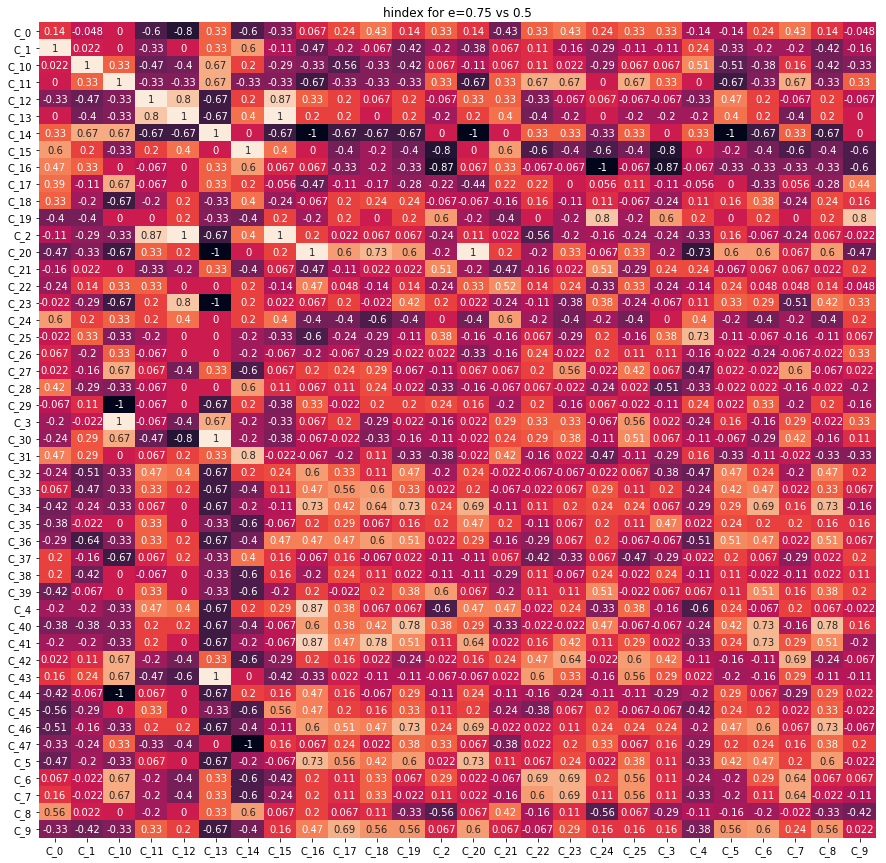

INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - executed kendall ranking on top users for each community


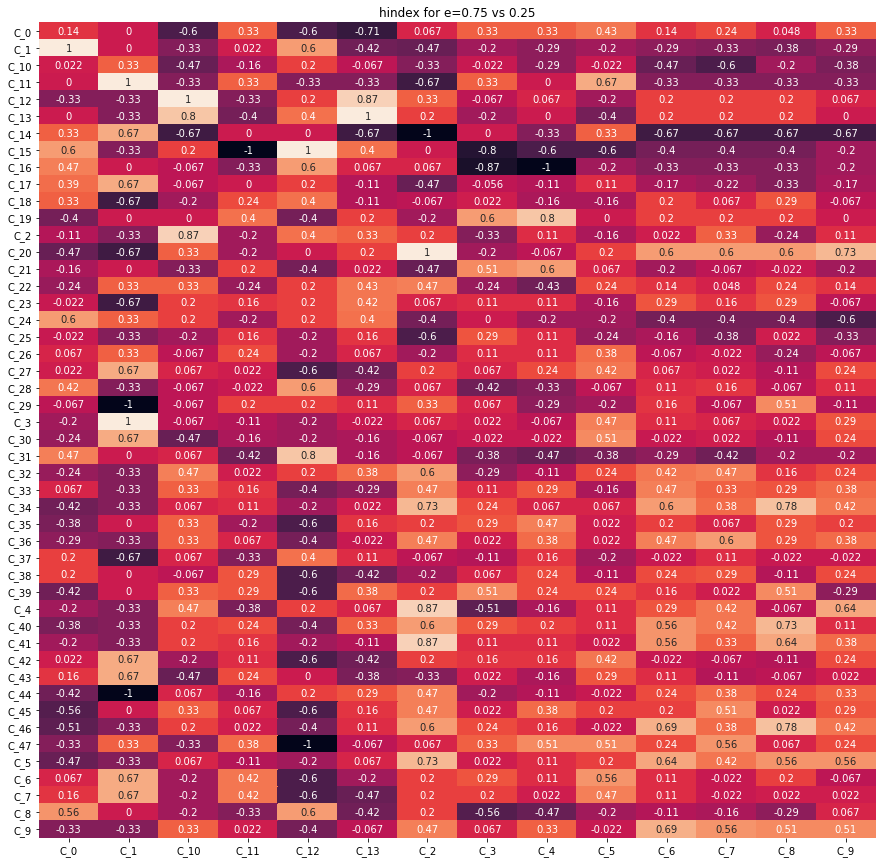

INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - executed kendall ranking on top users for each community


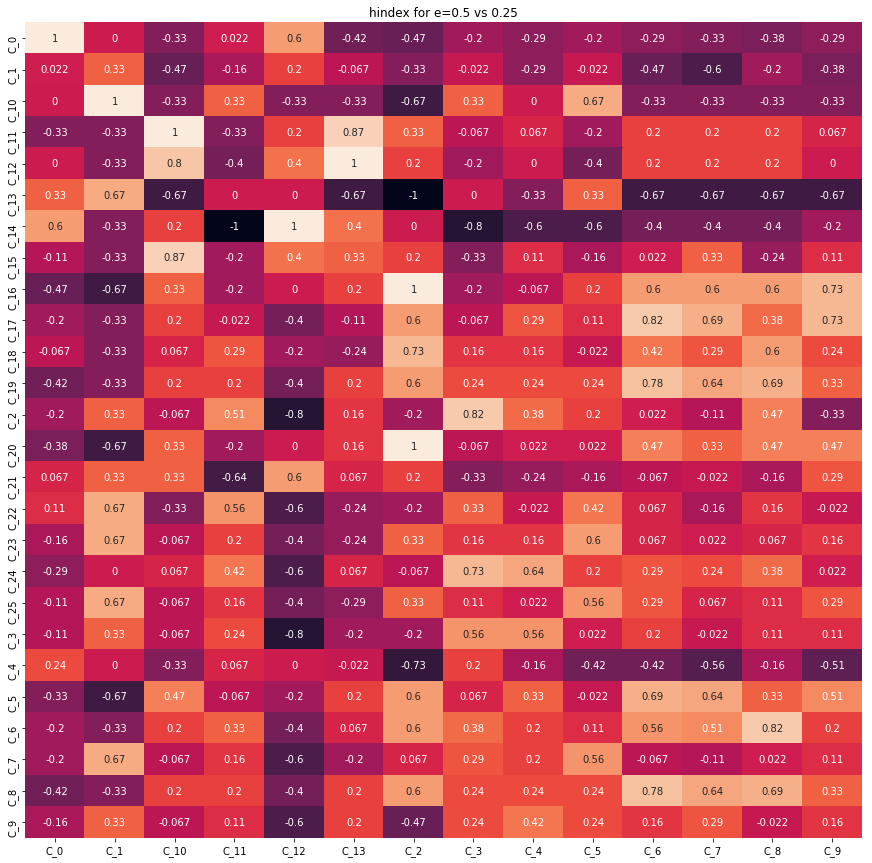

INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - top 10 for HINDEX
INFO - root - top users for each community


kdd


INFO - root - executed kendall ranking on top users for each community


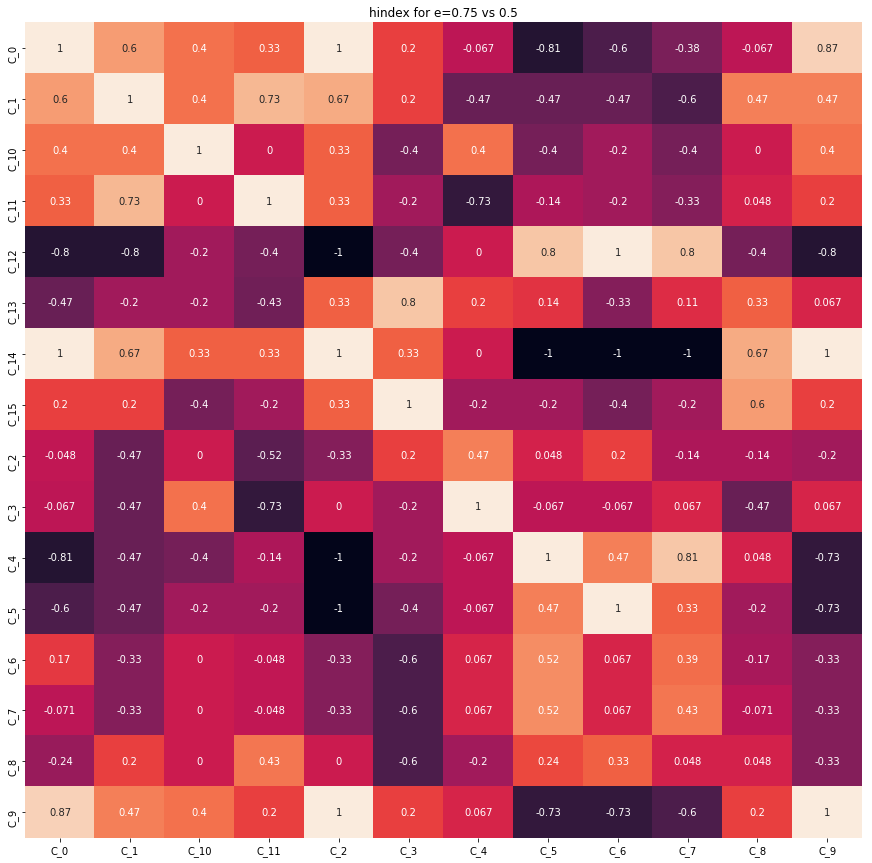

INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - executed kendall ranking on top users for each community


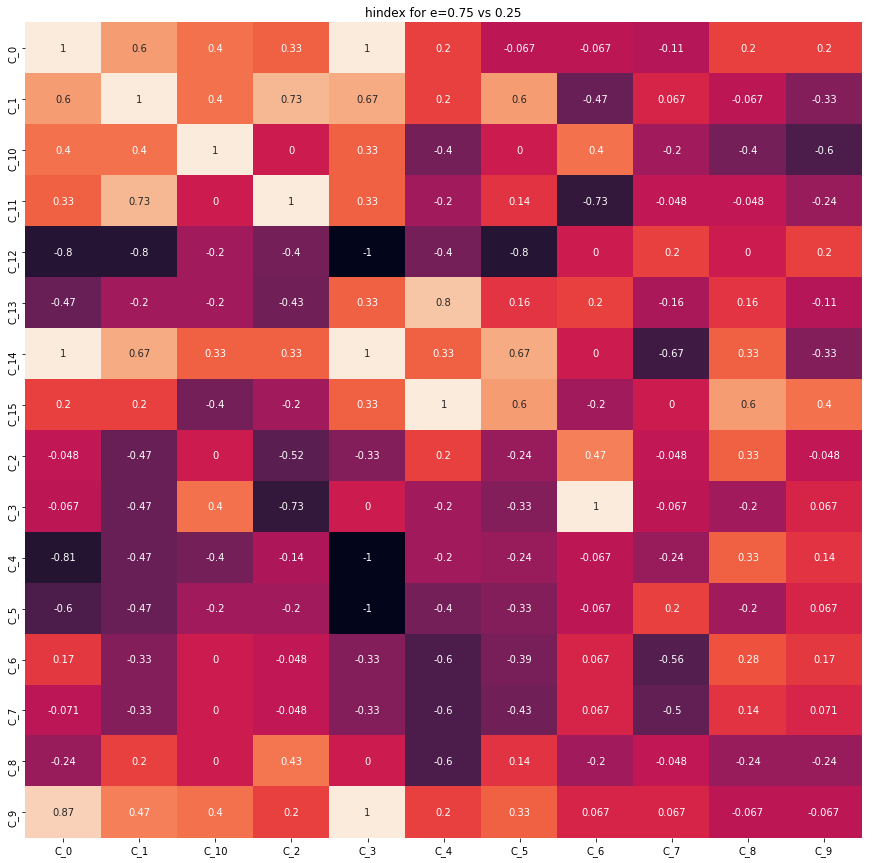

INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - top 10 for HINDEX
INFO - root - top users for each community
INFO - root - executed kendall ranking on top users for each community


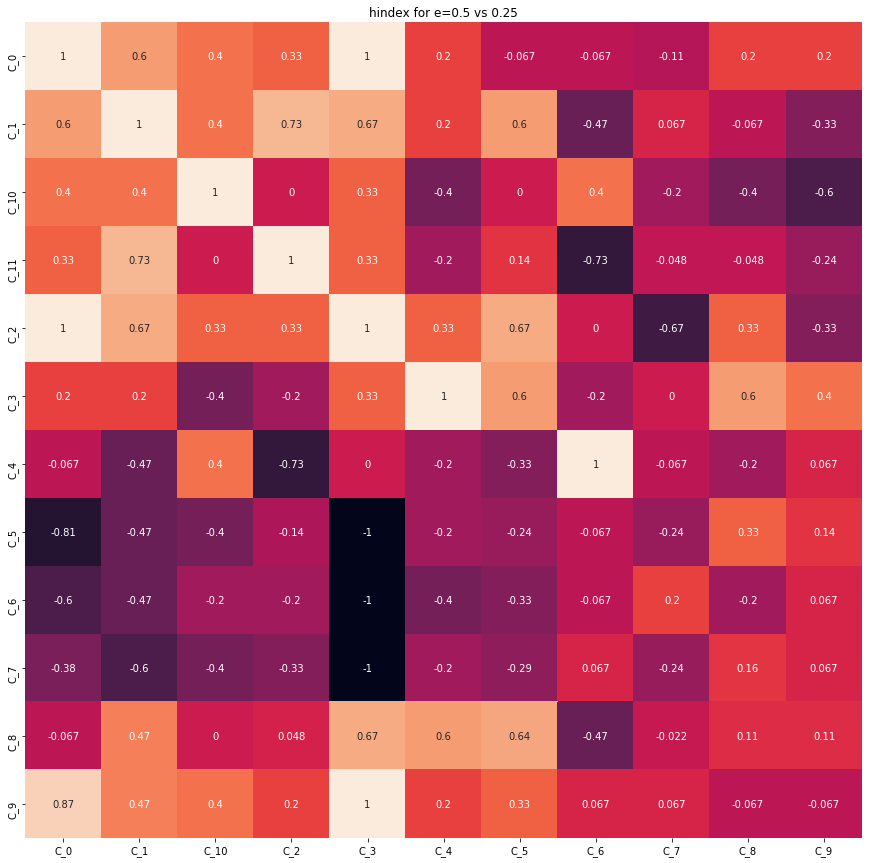

In [6]:
for data_fn in data_filenames:
    print(data_fn)
    for x, y in helper.pairwise_combinations(sorted(epsilon, reverse=True)):
        p1 = Metrics.metric_top(m[data_fn][x].metric_top_values('hindex'))
        p2 = Metrics.metric_top(m[data_fn][y].metric_top_values('hindex'))

        hm = Metrics.compare_metric_top(p1, p2)

        plt.figure(figsize = (15, 15))
        ax = sns.heatmap(hm, annot=True, cbar=False).set_title(f'hindex for e={x} vs {y}')
        plt.show()